# TimeDB Quickstart

Get started with TimeDB in 5 minutes. Learn how to store and query time series data with forecast revisions.

## 1. Setup

Import TimeDB.

In [1]:
import timedb as tb
import pandas as pd
import random
from datetime import datetime, timedelta, timezone
import math

tb.delete()
tb.create()

Creating database schema...
✓ Schema created successfully


## 2. Create a Series

A series is identified by its name and optional labels. Since this is forecast data, we set `overlapping=True`.

In [2]:
series_id = tb.create_series(
    name='wind_power',
    unit='MW',
    labels={'site': 'offshore_1', 'type': 'forecast'},
    overlapping=True
)

# See what was created
for s in tb.series('wind_power').list_series():
    print(f"  id={s['series_id']}  name={s['name']}  unit={s['unit']}  labels={s['labels']}  overlapping={s['overlapping']}")

  id=1  name=wind_power  unit=MW  labels={'site': 'offshore_1', 'type': 'forecast'}  overlapping=True


## 3. Insert Data

Insert time series data with a DataFrame. The `known_time` indicates when the forecast was made.

In [3]:
# Create forecast data
known_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
times = [known_time + timedelta(hours=i) for i in range(24)]
values = [100 + 30 * math.sin((i - 6) * math.pi / 12) + i/4*random.randint(-2, 2) for i in range(24)]

df = pd.DataFrame({
    'valid_time': times,
    'value': values
})

# Insert with known_time (when forecast was made)
tb.series('wind_power').where(site='offshore_1', type='forecast').insert(
    df=df,
    known_time=known_time
)

InsertResult(batch_id=1, workflow_id='sdk-workflow', series_id=1)

## 4. Insert a Revised Forecast

Insert an updated forecast for the same time period with a new `known_time`.

In [4]:
# Create revised forecast (made 6 hours later) - same valid_time range shows how forecast changed
revised_known = known_time + timedelta(hours=6)
# revised_values = [105 + 28 * math.sin((i - 7) * math.pi / 12) for i in range(24)]  # Slightly shifted pattern
revised_values = [100 + 30 * math.sin((i - 6) * math.pi / 12) + i/4*random.randint(-2, 2) for i in range(6, 30)]

df_revised = pd.DataFrame({
    'valid_time': [t + timedelta(hours=6) for t in times],
    'value': revised_values
})

tb.series('wind_power').where(site='offshore_1', type='forecast').insert(
    df=df_revised,
    known_time=revised_known
)

InsertResult(batch_id=2, workflow_id='sdk-workflow', series_id=1)

## 5. Read Latest Values

Get the most recent forecast for each time point.

In [5]:
# Read latest forecast values
df_latest = tb.series('wind_power').where(site='offshore_1', type='forecast').read(
    start_valid=known_time,
    end_valid=revised_known + timedelta(hours=24)
)
df_latest.head(10)

,value
valid_time,
2025-01-01 00:00:00+00:00,70.000000
2025-01-01 01:00:00+00:00,70.522225
2025-01-01 02:00:00+00:00,73.019238
2025-01-01 03:00:00+00:00,78.786797
2025-01-01 04:00:00+00:00,87.000000
2025-01-01 05:00:00+00:00,93.485429
2025-01-01 06:00:00+00:00,103.000000
2025-01-01 07:00:00+00:00,106.014571
2025-01-01 08:00:00+00:00,113.000000


## 6. Read All Forecast Revisions

Get all forecast versions to see how predictions changed over time.

In [6]:
# Read all forecast revisions
df_all = tb.series('wind_power').where(site='offshore_1', type='forecast').read(
    start_valid=known_time,
    end_valid=revised_known + timedelta(hours=24),
    versions=True
)
print(f"All revisions (multi-index: known_time, valid_time):")
df_all.head(10)

All revisions (multi-index: known_time, valid_time):


value
known_time                valid_time                           
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00   70.000000
                          2025-01-01 01:00:00+00:00   70.522225
                          2025-01-01 02:00:00+00:00   73.019238
                          2025-01-01 03:00:00+00:00   78.786797
                          2025-01-01 04:00:00+00:00   87.000000
                          2025-01-01 05:00:00+00:00   93.485429
                          2025-01-01 06:00:00+00:00  103.000000
                          2025-01-01 07:00:00+00:00  111.264571
                          2025-01-01 08:00:00+00:00  119.000000
                          2025-01-01 09:00:00+00:00  123.463203

## 7. Compare Forecasts

Visualize how the forecast changed between revisions.

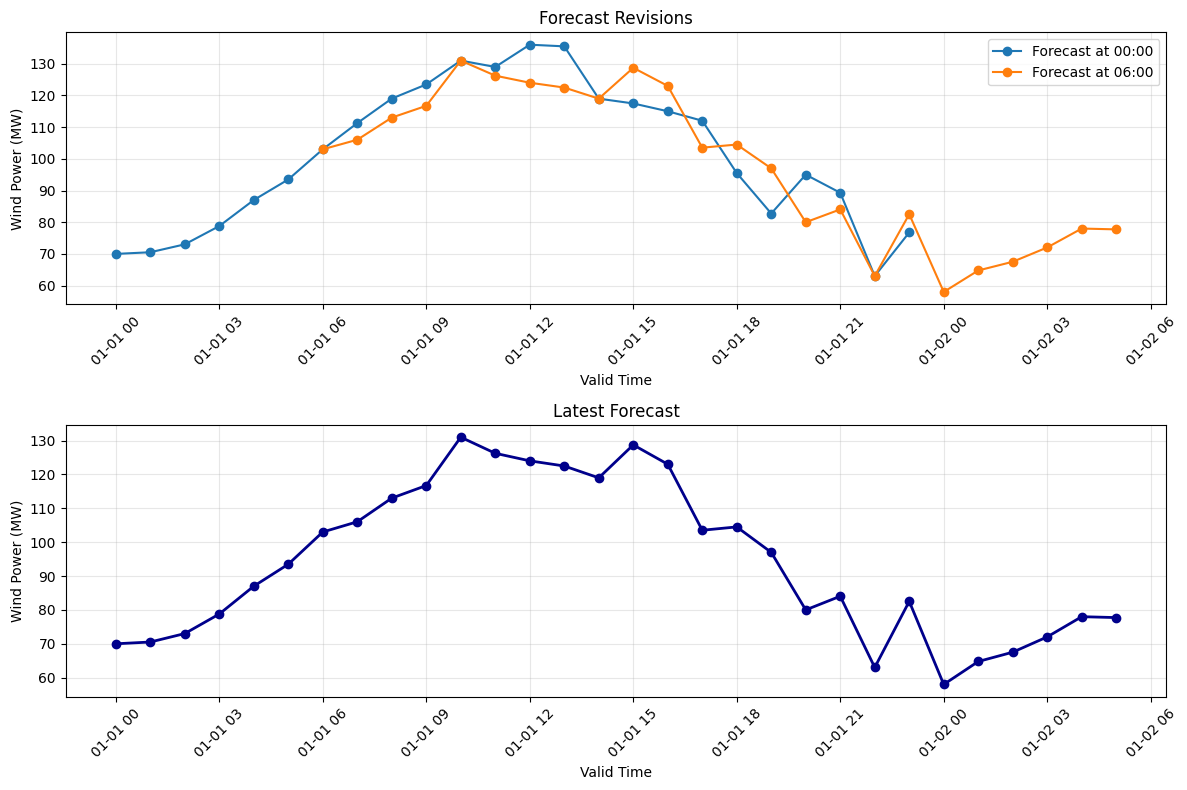

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

for known_time, data in df_all.groupby(level='known_time'):
    ax1.plot(data.index.get_level_values('valid_time'), data['value'].values, marker='o', label=f'Forecast at {known_time.strftime("%H:%M")}')

ax1.set_xlabel('Valid Time'), ax1.set_ylabel('Wind Power (MW)'), ax1.set_title('Forecast Revisions')
ax1.legend(), ax1.grid(True, alpha=0.3), ax1.tick_params(axis='x', rotation=45)

ax2.plot(df_latest.index.get_level_values('valid_time'), df_latest['value'], marker='o', linewidth=2, color='darkblue')
ax2.set_xlabel('Valid Time'), ax2.set_ylabel('Wind Power (MW)'), ax2.set_title('Latest Forecast')
ax2.grid(True, alpha=0.3), ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Summary

You've learned the basics of TimeDB:

1. **Create series** - Define your time series with name, unit, labels, and `overlapping=True` for versioned data
2. **Insert data** - Store forecasts with `known_time` using `insert()`
3. **Read latest** - Get the most recent forecast for each time point using `read()`
4. **Read revisions** - Access all forecast versions using `read(versions=True)` to analyze changes

### Key Concepts

- **`valid_time`**: The time period being forecasted
- **`known_time`**: When the forecast was made
- **`overlapping`**: `False` (default) for immutable facts, `True` for versioned forecasts
- **Series Collection**: Use `.series().where()` to filter by name and labels
- **Forecast Revisions**: Multiple forecasts for the same `valid_time` with different `known_time`

### Next Steps

- Check out `nb_03_forecast_revisions.ipynb` for more detailed examples
- Explore other notebooks for advanced features